In [249]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from termcolor import colored
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [250]:
path = 'data/ckd-dataset-v2.csv'
df = pd.read_csv(path)

df.head()


,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12


## Data cleaning

In [251]:
# drop columns with all missing values
df = df.dropna(how='all')
# first let's drop the first two rows that are immediately visible to be useless
df = df.iloc[2:].reset_index(drop=True)

# inspct row 1
df.iloc[1]

bp (Diastolic)                0
bp limit                      0
sg                1.009 - 1.011
al                          < 0
class                       ckd
rbc                           0
su                          < 0
pc                            0
pcc                           0
ba                            0
bgr                   112 - 154
bu                       < 48.1
sod                   133 - 138
sc                       < 3.65
pot                      < 7.31
hemo                11.3 - 12.6
pcv                 33.5 - 37.4
rbcc                4.46 - 5.05
wbcc              12120 - 14500
htn                           0
dm                            0
cad                           0
appet                         0
pe                            0
ane                           0
grf                   ≥ 227.944
stage                        s1
affected                      1
age                        < 12
Name: 1, dtype: object

In [252]:
# verify changes so far
df.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
1,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
2,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12
3,1,1,1.009 - 1.011,3 - 3,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,127.281 - 152.446,s1,1,< 12
4,0,0,1.015 - 1.017,< 0,ckd,0,< 0,0,0,0,...,0,1,0,1,1,0,127.281 - 152.446,s1,1,12 - 20


In [253]:
# find nan values
df.isnull().sum()

bp (Diastolic)    0
bp limit          0
sg                0
al                0
class             0
rbc               0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sod               0
sc                0
pot               0
hemo              0
pcv               0
rbcc              0
wbcc              0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
grf               0
stage             0
affected          0
age               0
dtype: int64

In [254]:
df.dtypes # just inspecting types

bp (Diastolic)    object
bp limit          object
sg                object
al                object
class             object
rbc               object
su                object
pc                object
pcc               object
ba                object
bgr               object
bu                object
sod               object
sc                object
pot               object
hemo              object
pcv               object
rbcc              object
wbcc              object
htn               object
dm                object
cad               object
appet             object
pe                object
ane               object
grf               object
stage             object
affected          object
age               object
dtype: object

In [255]:
# rename columns with spaces in the name
df.rename(columns={'bp (Diastolic)': 'bp_diastolic'}, inplace=True)
df.rename(columns={'bp limit': 'bp_limit'}, inplace=True)
df.rename(columns={'class': 'has_ckd'}, inplace=True)

In [256]:
df.columns

Index(['bp_diastolic', 'bp_limit', 'sg', 'al', 'has_ckd', 'rbc', 'su', 'pc',
       'pcc', 'ba', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc',
       'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'grf', 'stage',
       'affected', 'age'],
      dtype='object')

In [257]:
# show count of unique values for each column
for col in df.columns:
    print(col, df[col].nunique())

bp_diastolic 2
bp_limit 3
sg 5
al 5
has_ckd 2
rbc 2
su 6
pc 2
pcc 2
ba 2
bgr 10
bu 8
sod 9
sc 7
pot 4
hemo 10
pcv 10
rbcc 9
wbcc 9
htn 2
dm 2
cad 2
appet 2
pe 2
ane 2
grf 11
stage 5
affected 2
age 10


In [258]:
# show unique values for each column (since we know there aren't any columns with overwhealmingly many unique values)
for col in df.columns:
    print(colored(col, 'green'), df[col].unique())

bp_diastolic ['0' '1']
bp_limit ['0' '1' '2']
sg ['1.019 - 1.021' '1.009 - 1.011' '1.015 - 1.017' '≥ 1.023' '< 1.007']
al ['1 - 1' '< 0' '≥ 4' '3 - 3' '2 - 2']
has_ckd ['ckd' 'notckd']
rbc ['0' '1']
su ['< 0' '4 - 4' '2 - 2' '3 - 4' '1 - 2' '≥ 4']
pc ['0' '1']
pcc ['0' '1']
ba ['0' '1']
bgr ['< 112' '112 - 154' '154 - 196' '406 - 448' '238 - 280' '196 - 238'
 '≥ 448' '280 - 322' '364 - 406' '322 - 364']
bu ['< 48.1' '48.1 - 86.2' '200.5 - 238.6' '124.3 - 162.4' '86.2 - 124.3'
 '162.4 - 200.5' '≥ 352.9' '238.6 - 276.7']
sod ['138 - 143' '133 - 138' '123 - 128' '143 - 148' '148 - 153' '< 118'
 '128 - 133' '118 - 123' '≥ 158']
sc ['< 3.65' '3.65 - 6.8' '16.25 - 19.4' '6.8 - 9.95' '13.1 - 16.25'
 '9.95 - 13.1' '≥ 28.85']
pot ['< 7.31' '≥ 42.59' '7.31 - 11.72' '38.18 - 42.59']
hemo ['11.3 - 12.6' '8.7 - 10' '13.9 - 15.2' '≥ 16.5' '10 - 11.3' '7.4 - 8.7'
 '12.6 - 13.9' '15.2 - 16.5' '< 6.1' '6.1 - 7.4']
pcv ['33.5 - 37.4' '29.6 - 33.5' '41.3 - 45.2' '37.4 - 41.3' '≥ 49.1'
 '21.8 - 25.7' '45.

In [259]:
# these columns already have valid numeric strings, so converting them to numeric first
to_numeric_1 = ['bp_diastolic', 'bp_limit', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad']
for col in to_numeric_1:
    df[col] = pd.to_numeric(df[col], errors='raise')

In [260]:
# turn class column into binary. cgk = 1, notckd = 0
df['has_ckd'] = df['has_ckd'].map({'ckd': 1, 'notckd': 0})
df['stage'] = df['stage'].map({'s1': 1, 's2': 2, 's3': 3, 's4': 4, 's5': 5})

In [261]:
def process_range(val):
    """This function processes the range values in the dataset and returns the average of the range.
    For < and ≥ values, it returns the lower and upper limits respectively.
    """
    try:
        # Try to convert directly to float (if it's already a valid number like '27')
        return float(val)
    except ValueError:
        # Handle ranges and comparisons
        if '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2  # Take the midpoint of the range
        elif '<' in val:
            return float(val.replace('<', '').strip())  # Return the lower limit
        elif '≥' in val:
            return float(val.replace('≥', '').strip())  # Return the upper limit
        else:
            return np.nan  # Return NaN for anything unexpected

In [262]:
# process the rest of the columns
for col in df.columns:
    if col not in to_numeric_1 + ['has_ckd', 'stage']:
        df[col] = df[col].apply(process_range)

In [263]:
df.dtypes # let's inspect the types again and confirm our changes

bp_diastolic      int64
bp_limit          int64
sg              float64
al              float64
has_ckd           int64
rbc               int64
su              float64
pc                int64
pcc               int64
ba                int64
bgr             float64
bu              float64
sod             float64
sc              float64
pot             float64
hemo            float64
pcv             float64
rbcc            float64
wbcc            float64
htn               int64
dm                int64
cad               int64
appet           float64
pe              float64
ane             float64
grf             float64
stage             int64
affected        float64
age             float64
dtype: object

In [264]:
df.isnull().sum() # check for missing values

bp_diastolic    0
bp_limit        0
sg              0
al              0
has_ckd         0
rbc             0
su              0
pc              0
pcc             0
ba              0
bgr             0
bu              0
sod             0
sc              0
pot             0
hemo            0
pcv             0
rbcc            0
wbcc            0
htn             0
dm              0
cad             0
appet           0
pe              0
ane             0
grf             1
stage           0
affected        0
age             0
dtype: int64

In [265]:
# We found that grf has 1 missing value, let's inspect it
df['grf'].unique()

array([227.944  , 139.8635 , 114.698  , 190.195  ,  39.20035,  64.3661 ,
        89.532  , 165.029  , 215.361  ,  26.6175 ,       nan])

In [266]:
# tried applying CDK-EPI formula to calculate GFR, but it didn't work out. (from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2866096/)
# The estimated values were way off
# instead let's use the mean value of the same class to fill in the missing values

# find row with NaN grf value
class_value = df[df['grf'].isnull()]['has_ckd']
print(f"class for missing grf: {class_value}")

# find median value of grf for the same class. Using median because we transformed ranges to single values
median_grf = df[df['has_ckd'] == 1]['grf'].median()
print(f"Median grf for class 1: {median_grf}")

# fill in the missing value if class == 1 and grf is NaN
df.loc[(df['has_ckd'] == 1) & (df['grf'].isnull()), 'grf'] = median_grf



class for missing grf: 179    1
Name: has_ckd, dtype: int64
Median grf for class 1: 26.6175


In [267]:
df.isnull().sum() # check again for missing values and confirm the fix

bp_diastolic    0
bp_limit        0
sg              0
al              0
has_ckd         0
rbc             0
su              0
pc              0
pcc             0
ba              0
bgr             0
bu              0
sod             0
sc              0
pot             0
hemo            0
pcv             0
rbcc            0
wbcc            0
htn             0
dm              0
cad             0
appet           0
pe              0
ane             0
grf             0
stage           0
affected        0
age             0
dtype: int64

In [268]:
clean_df = df.copy() # make a copy of the cleaned dataframe for later use

In [269]:
def pretty_print_dict(d, accentKeys=[]):
    """Helper function to print dictionary values with color"""
    for key in accentKeys:
        if key in d:
            print(f"{key}: {colored(round(d[key], 4), 'green')}")
    for key, value in d.items():
        if key not in accentKeys:
            print(f"{key}: {colored(round(value, 4), 'yellow')}")



## Prediction objectives and strategy:
1. Replicate the findings from [this paper](https://www.semanticscholar.org/paper/Risk-Factor-Prediction-of-Chronic-Kidney-Disease-on-Islam-Akter/a4b90dd7b9dfaffa9eff1efc6555bbce62a963d7). We will focus on Linear Regression.
2. Investigate ways to improve the model and compare with the paper's predictions
3. Implement a Logistic Regression for this problem. We believe using a Logistic Regression is more appropriate than a Linear Regression because the has_ckd feature is Binomial
4. Compare the results and arrive at a conclusion

### Replicating the Linear Regression

#### The RF-CDK study published the following models and model prediction functions:
![title](rf-ckd-model-weights.png)

In [270]:
def linear_regression(X, y, show_results=True):
    """Helper function for creating a linear regression model and returning the results"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    coefficients = model.coef_
    intercept = model.intercept_

    results = {
        'intercept': intercept,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred)
    }
    for feature, coef in zip(X.columns, coefficients):
        results[feature] = coef
    
    if show_results:
        pretty_print_dict(results, accentKeys=['r2', 'mse'])
    return results, model

In [271]:
# The LR model in the paper we want to replicate used these exact features
X = df[['bu', 'hemo', 'wbcc', 'rbcc', 'htn']]
y = df['has_ckd']
replica_model = linear_regression(X, y)

r2: 0.616
mse: 0.09
intercept: 2.2105
bu: -0.0004
hemo: -0.1018
wbcc: 0.0
rbcc: -0.0893
htn: 0.2129


#### Observations thus far
- We were not able to replicate the exact prediction function as in the study, but we were pretty close in terms of coefficients. It is safe to assume that the performance of this replicated model is the same as in the study

#### Comparing the replica model with a custom made model using the exact coefficients as in the study

In [272]:
# Using same weights as the rfckd study: https://ieeexplore.ieee.org/document/9315878
def manual_linear_regression(X):
    predictions = (
        X['bu'] * -0.0002 +
        X['hemo'] * -0.091 +
        X['wbcc'] * 0.0 +  # wbcc has no effect
        X['rbcc'] * -0.0076 +
        X['htn'] * 0.288 +
        1.5892  # Intercept
    )
    return predictions

y_pred_manual = manual_linear_regression(X)
r2_manual = r2_score(y, y_pred_manual)
mse_manual = mean_squared_error(y, y_pred_manual)

print(f"Manual Model R-squared: {round(r2_manual, 4)}")
print(f"Manual Model Mean Squared Error: {round(mse_manual, 4)}")

Manual Model R-squared: 0.5766
Manual Model Mean Squared Error: 0.0976


The R-squared of the replica is 0.616, while using the exact parameters, the R-squared is 0.576. The parameters in the replica create better predictors based on the current data

In [273]:
# First let's inspect the p-values of the features
X = df[['bp_diastolic', 'bp_limit', 'sg', 'al', 'rbc', 'su', 'pc',
       'pcc', 'ba', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc',
       'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'grf', 'age']]
y = df['has_ckd']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                has_ckd   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     24.92
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           1.69e-45
Time:                        00:22:10   Log-Likelihood:                 18.707
No. Observations:                 200   AIC:                             16.59
Df Residuals:                     173   BIC:                             105.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.6034      4.478      6.611   

In [274]:
# get the p-values from the model
p_values = model.pvalues
p_values_lt_than_0_05 = p_values[p_values < 0.05]
del p_values_lt_than_0_05['const']

print(pretty_print_dict(p_values_lt_than_0_05))
significant_features = p_values_lt_than_0_05.index

bp_limit: 0.0302
sg: 0.0
al: 0.0446
hemo: 0.0
ane: 0.0047
grf: 0.0021
None


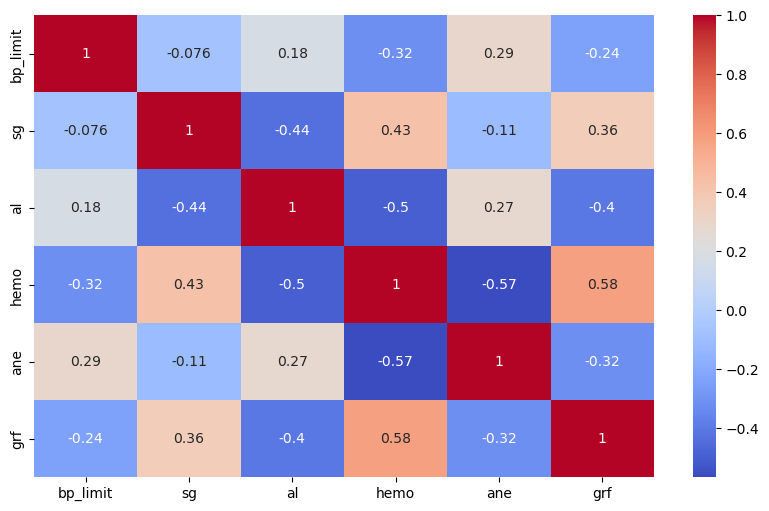

In [275]:
# In order to find the best features, we can start by inspecting the correlation matrix
corr_matrix = df[significant_features].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

No significant correlation found among the remaining features

In [276]:
# Now, we'll do a cross-validated linear regression model with remaining features
X = df[list(significant_features)]
y = df['has_ckd']

# Initialize and cross-validate the model
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring="r2")  # R-squared scoring
print(f"Using these features: {list(significant_features)}")
print("Cross-Validated R-squared scores:", cv_scores)
print("Mean R-squared from cross-validation:", cv_scores.mean())


Using these features: ['bp_limit', 'sg', 'al', 'hemo', 'ane', 'grf']
Cross-Validated R-squared scores: [0.40951505 0.71602613 0.76125971 0.72337089 0.76407239]
Mean R-squared from cross-validation: 0.6748488332028546


The cross-validated R-squared scores range from approximately 0.41 to 0.76, with a mean R-squared of 0.675. This mean R-squared suggests that the model explains about 67.5% of the variance in the target variable (`has_ckd`) across different data splits, indicating moderate predictive power. 

The variability in individual R-squared scores across folds (from 0.41 to 0.76) suggests that model performance is somewhat dependent on the specific subset of data used in each fold. While the model shows reasonable generalizability, further tuning or additional predictors could potentially stabilize performance across data splits.

Still, this is slightly better than the replica model

In [277]:
model = LinearRegression()
rfecv = RFECV(estimator=model, step=1, cv=5, scoring="r2")
rfecv.fit(X, y)

print("Optimal number of features:", rfecv.n_features_)
print("Best features:", X.columns[rfecv.support_])

Optimal number of features: 6
Best features: Index(['bp_limit', 'sg', 'al', 'hemo', 'ane', 'grf'], dtype='object')


In [278]:
results, model = linear_regression(X, y) # winning model
linear_regression_winning_model, linear_regression_winning_results = model, results

r2: 0.7192
mse: 0.0658
intercept: 34.8392
bp_limit: 0.033
sg: -32.3444
al: 0.0355
hemo: -0.1009
ane: -0.1223
grf: -0.0013


#### Result
This model performs better than the previous best (replica model) both in r-squared and mse.

### Logistic Regression

In [279]:
df = clean_df.copy() # reset the dataframe to the cleaned version
df.head()

,bp_diastolic,bp_limit,sg,al,has_ckd,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,0,0,1.020,1.0,1,0,0.0,0,0,0,...,0,0,0,0.0,0.0,0.0,227.9440,1,1.0,12.0
1,0,0,1.010,0.0,1,0,0.0,0,0,0,...,0,0,0,0.0,0.0,0.0,227.9440,1,1.0,12.0
2,0,0,1.010,4.0,1,1,0.0,1,0,1,...,0,0,0,1.0,0.0,0.0,139.8635,1,1.0,12.0
3,1,1,1.010,3.0,1,0,0.0,0,0,0,...,0,0,0,0.0,0.0,0.0,139.8635,1,1.0,12.0
4,0,0,1.016,0.0,1,0,0.0,0,0,0,...,0,1,0,1.0,1.0,0.0,139.8635,1,1.0,16.0


#### Correlation Matrix
If you see any pairs with high correlations (> 0.7), you may need to remove one of the correlated features or apply dimensionality reduction

          bp_limit        sg        al       ane      hemo      rbcc  \
bp_limit  1.000000 -0.076103  0.178445  0.285984 -0.322233 -0.211596   
sg       -0.076103  1.000000 -0.437849 -0.111426  0.425092  0.424160   
al        0.178445 -0.437849  1.000000  0.273904 -0.497136 -0.410913   
ane       0.285984 -0.111426  0.273904  1.000000 -0.567110 -0.382500   
hemo     -0.322233  0.425092 -0.497136 -0.567110  1.000000  0.638086   
rbcc     -0.211596  0.424160 -0.410913 -0.382500  0.638086  1.000000   
htn       0.180106 -0.306306  0.475734  0.294164 -0.573199 -0.510611   
grf      -0.242316  0.357467 -0.401874 -0.320872  0.579358  0.420097   
bu        0.200774 -0.198337  0.359884  0.482338 -0.480684 -0.389282   

               htn       grf        bu  
bp_limit  0.180106 -0.242316  0.200774  
sg       -0.306306  0.357467 -0.198337  
al        0.475734 -0.401874  0.359884  
ane       0.294164 -0.320872  0.482338  
hemo     -0.573199  0.579358 -0.480684  
rbcc     -0.510611  0.420097 -0.3

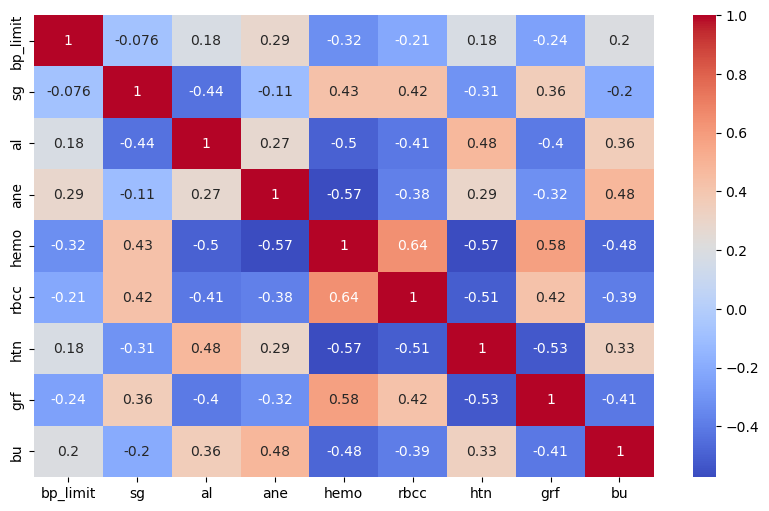

In [280]:
X = df[['bp_limit', 'sg', 'al', 'ane', 'hemo', 'rbcc', 'htn', 'grf', 'bu']]

# Compute the correlation matrix
corr_matrix = X.corr()
print(corr_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

The correlation between rbcc and hemo is slightly high

In [281]:
df.columns

Index(['bp_diastolic', 'bp_limit', 'sg', 'al', 'has_ckd', 'rbc', 'su', 'pc',
       'pcc', 'ba', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc',
       'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'grf', 'stage',
       'affected', 'age'],
      dtype='object')

#### Variance Inflation Factor
VIF quantifies how much a feature's variance is inflated due to collinearity with other features. A VIF above 5–10 suggests high collinearity, and the feature should be considered for removal.

In [282]:
def calculate_vif(X, threshold=10):
    # Loop to drop features with VIF > threshold
    while True:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        # Check if all VIFs are below the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif < threshold:
            break

        # Drop the feature with the highest VIF
        feature_to_drop = vif_data.sort_values("VIF", ascending=False)["Feature"].iloc[0]
        print(f"Dropping '{feature_to_drop}' with VIF: {max_vif}")
        X = X.drop(columns=[feature_to_drop])

    return X, vif_data

# Apply the function to your features
X_reduced, final_vif_data = calculate_vif(X, threshold=10)

# Print final VIFs for the reduced feature set
print("Final features and VIFs after reduction:")
print(final_vif_data)

Dropping 'sg' with VIF: 100.4979434346956
Dropping 'hemo' with VIF: 44.05659752808901
Final features and VIFs after reduction:
    Feature       VIF
0  bp_limit  2.064446
1        al  2.153475
2       ane  1.701939
3      rbcc  8.329626
4       htn  2.373360
5       grf  4.121285
6        bu  4.777806


-----> **A VIF > 10 is generally considered high. Results look good

In [283]:
def logistic_regression(X, y, show_results=True):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the logistic regression model
    model = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    class_report = classification_report(y_test, y_pred, target_names=["No CKD", "CKD"])  # Use output_dict to access specific values

    if show_results:
        print(class_report)

    # Return the trained model and evaluation results
    return model, class_report

In [284]:
# approach 0: Test with all features after VIF reduction
X = X_reduced
y = df['has_ckd']
model =logistic_regression(X, y);


              precision    recall  f1-score   support

      No CKD       0.94      1.00      0.97        15
         CKD       1.00      0.96      0.98        25

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



In [285]:
# Approach 1: Use the features from the winning linear regression model
X = df[['bp_limit', 'sg', 'al', 'hemo', 'ane', 'grf']]
y = df['has_ckd']

# variable name added after the fact
logistic_regression_winning_model = logistic_regression(X, y); # winning model

              precision    recall  f1-score   support

      No CKD       1.00      0.87      0.93        15
         CKD       0.93      1.00      0.96        25

    accuracy                           0.95        40
   macro avg       0.96      0.93      0.95        40
weighted avg       0.95      0.95      0.95        40



In [286]:
# Approach 3. 
# a. Remove one of hemo or rbcc; b. Combine hemo and rbcc into one feature by averaging them

# Approach 3a_1: Remove hemo (turns out it was already dropped by VIF)
# X = X_reduced.drop(columns=['hemo'])
# y = df['has_ckd']
# model = logistic_regression(X, y);

# The model is too perfect, which is suspicious. There's possible overfitting.

In [287]:
# Approach 3a_2: Remove rbcc (but include hemo)
X = df[['hemo'] + X_reduced.columns.tolist()].drop(columns=['rbcc'])
y = df['has_ckd']
model = logistic_regression(X, y);

              precision    recall  f1-score   support

      No CKD       1.00      0.87      0.93        15
         CKD       0.93      1.00      0.96        25

    accuracy                           0.95        40
   macro avg       0.96      0.93      0.95        40
weighted avg       0.95      0.95      0.95        40



In [288]:
X_reduced.columns

Index(['bp_limit', 'al', 'ane', 'rbcc', 'htn', 'grf', 'bu'], dtype='object')

In [289]:
# Approach 3b
df['hemo_rbcc'] = (df['hemo'] + df['rbcc']) / 2
X = df[['bp_limit', 'al', 'ane', 'hemo_rbcc', 'htn', 'grf', 'bu']] # combined hemo and rbcc
y = df['has_ckd']
logistic_regression_model_2 = logistic_regression(X, y);

              precision    recall  f1-score   support

      No CKD       1.00      0.93      0.97        15
         CKD       0.96      1.00      0.98        25

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [ ]:
logistic_regression_winning_model = 

#### Conclusion
Using the features obtained after performing VIF yielded best results. Although, combining hemo + rbcc performed almost equal

### Comparing results of Logistic Regression with Linear Regression

In [74]:
# The winning Linear Regression model is in the r2 variable
print("--- Linear model 2 ---")
pretty_print_dict(r2, accentKeys=['r2', 'mse'])
print("\n--- Logistic model 2---")
pretty_print_dict(results_2, accentKeys=['accuracy', 'precision', 'recall', 'f1_score'])


--- Linear model 2 ---
r2: 0.6953
mse: 0.0714
intercept: 2.2116
hemo: -0.0899
rbcc: -0.0916
htn: 0.172
grf: -0.0014

--- Logistic model 2---
accuracy: 0.975
precision: 0.9615
recall: 1.0
f1_score: 0.9804
intercept: 19.936
hemo_rbcc: -2.2895
htn: 1.6565
grf: -0.006
bu: 0.027


,bp_diastolic,bp_limit,sg,al,has_ckd,rbc,su,pc,pcc,ba,...,dm,cad,appet,pe,ane,grf,stage,affected,age,hemo_rbcc
0,0,0,1.020,1.0,1,0,0.0,0,0,0,...,0,0,0.0,0.0,0.0,227.9440,1,1.0,12.0,8.3525
1,0,0,1.010,0.0,1,0,0.0,0,0,0,...,0,0,0.0,0.0,0.0,227.9440,1,1.0,12.0,8.3525
2,0,0,1.010,4.0,1,1,0.0,1,0,1,...,0,0,1.0,0.0,0.0,139.8635,1,1.0,12.0,7.0525
3,1,1,1.010,3.0,1,0,0.0,0,0,0,...,0,0,0.0,0.0,0.0,139.8635,1,1.0,12.0,9.6525
4,0,0,1.016,0.0,1,0,0.0,0,0,0,...,1,0,1.0,1.0,0.0,139.8635,1,1.0,16.0,9.9475


In [83]:
# compare linear and logistic regression models performance
X_logistic = df[['hemo_rbcc', 'htn', 'grf', 'bu']]  # For logistic regression
X_linear = df[['hemo', 'rbcc', 'htn', 'grf']]       # For linear regression
y = df['has_ckd']  # Binary target variable

# Split the data for training and testing
X_log_train, X_log_test, y_train, y_test = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_lin_train, X_lin_test, _, _ = train_test_split(X_linear, y, test_size=0.2, random_state=42)

# Step 2: Fit the Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_log_train, y_train)
logistic_y_pred = logistic_model.predict(X_log_test)

# Step 3: Fit the Linear Regression Model and Convert Predictions to Binary
linear_model = LinearRegression()
linear_model.fit(X_lin_train, y_train)
linear_y_pred_continuous = linear_model.predict(X_lin_test)
linear_y_pred_binary = (linear_y_pred_continuous >= 0.5).astype(int)  # Apply a threshold of 0.5 for binary classification

# Step 4: Evaluate Both Models
# Logistic Regression Metrics
logistic_accuracy = accuracy_score(y_test, logistic_y_pred)
logistic_precision = precision_score(y_test, logistic_y_pred)
logistic_recall = recall_score(y_test, logistic_y_pred)
logistic_f1 = f1_score(y_test, logistic_y_pred)

# Linear Regression Metrics (after thresholding predictions)
linear_accuracy = accuracy_score(y_test, linear_y_pred_binary)
linear_precision = precision_score(y_test, linear_y_pred_binary)
linear_recall = recall_score(y_test, linear_y_pred_binary)
linear_f1 = f1_score(y_test, linear_y_pred_binary)

# Final Summary
print("\nComparison Summary:")
print("Logistic:                   :", {"accuracy": logistic_accuracy, "precision": logistic_precision, 
                               "recall": logistic_recall, "f1_score": logistic_f1})
print("Linear (w/ binary threshold):", {"accuracy": linear_accuracy, "precision": linear_precision, 
                                                "recall": linear_recall, "f1_score": linear_f1})


Comparison Summary:
Logistic:                   : {'accuracy': 0.975, 'precision': 0.9615384615384616, 'recall': 1.0, 'f1_score': 0.9803921568627451}
Linear (w/ binary threshold): {'accuracy': 0.975, 'precision': 0.9615384615384616, 'recall': 1.0, 'f1_score': 0.9803921568627451}


It is interesting that both models have the same accuracy, precision, recall, and F1-score.
Maybe we shouldn't include this in our final report as it is an unusual result.

The chosen threshold (0.5) for the linear regression model might align well with the logistic model’s decision boundary, leading to similar predictions. Changing this threshold could reveal more differences, though 0.5 is typically a reasonable choice.
